In [17]:
import sys
sys.path.append('/Users/aakash/anaconda3/envs/gis/lib/python3.6/site-packages')
import ee
import eefuncs as eef
import eesats as ees
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import warnings
from itertools import product
import time
plt.rcParams["figure.figsize"] = (15,10)


warnings.filterwarnings('ignore')
ee.Initialize()

# Define parameters

In [2]:
# Set the Study area (upoad kml to google fusion table, use the DocID in the ft string below)
area = (ee.FeatureCollection('ft:1QPasan0i6O9uUlcYkjqj91D7mbnhTZCmzS4t7t_g').filter(ee.Filter.eq('id', '055')))
bounds = area.geometry().bounds()


# Set the study years
years = [x for x in range(2000, 2018)] # 2000 - 2015
year = years[-1]
start = ee.Date.fromYMD(year,1,1)
end = start.advance(1,'month')

# Landsats and clouds

In [3]:
def get_landsat(year):
    
    '''
    select the appropriate landsat based on years 
    '''
    
    landsats = {"L4":ee.ImageCollection('LANDSAT/LT04/C01/T1_SR'), 
            "L5": ee.ImageCollection('LANDSAT/LT05/C01/T1_SR'),
            "L7":ee.ImageCollection('LANDSAT/LE07/C01/T1_SR'),
            "L8":ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")}
    
    if year < 1982 : 
        print("No landsat available")
    if year < 1993 and year > 1982:
        landsat = landsats['L4']
    if year < 2012 and year >1993:
        landsat = landsats['L5']
    else: 
        landsat = landsats['L8']
        
    return landsat

def get_QA_bits(image, start, end, field_name):
    
    '''
    retrieve quality bits from landsat
    '''
    
    pattern = 0
    for i in range(start,end+1):
        pattern += 2**i
    return image.select([0], [field_name]).bitwiseAnd(pattern).rightShift(start)

def mask_quality(image):
    
    '''
    mask clouds and shoaws from landsat
    '''
    
    QA = image.select('pixel_qa')
    # Get the internal_cloud_algorithm_flag bit.
    shad = get_QA_bits(QA,3,3,'cloud_shadow')
    cloud = get_QA_bits(QA,5,5,'cloud')
    cirrus_detected = get_QA_bits(QA,9,9,'cirrus_detected')
    #Return an image masking out cloudy areas.
    return image.updateMask(shad.eq(0)).updateMask(cloud.eq(0).updateMask(cirrus_detected.eq(0)))


# Data processing

In [9]:
def array_from_col(col,res,bounds=bounds,year=2017,month=1,day=1, band = "B1"):
    start = ee.Date.fromYMD(year,month,day)
    end = start.advance(1,'year')
    col = get_landsat(year).filterBounds(area).filterDate(start, end).map(mask_quality)
    
    # get the lat lon and add the band and scale by the appropriate factor (0.0001 for landsat)
    band_name = col.select(band).median()
    latlon = ee.Image.pixelLonLat().addBands(band_name).multiply(0.0001)

    # apply reducer to list
    latlon = latlon.reduceRegion(
      reducer=ee.Reducer.toList(),
      geometry=bounds,
      maxPixels=1e13,
      scale=res)
    
    data = np.array((ee.Array(latlon.get(band)).getInfo()))
    lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
    lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))
    
    arr = array_from_reducer(data,lats,lons)
    
    return (arr)

def array_from_reducer(data,lats,lons):
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32) #-9999

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] 
                
    return arr

# Main

In [10]:
col = get_landsat(year).filterBounds(bounds).filterDate(start, end).map(mask_quality)

In [11]:
im = array_from_col(col,res = 70)

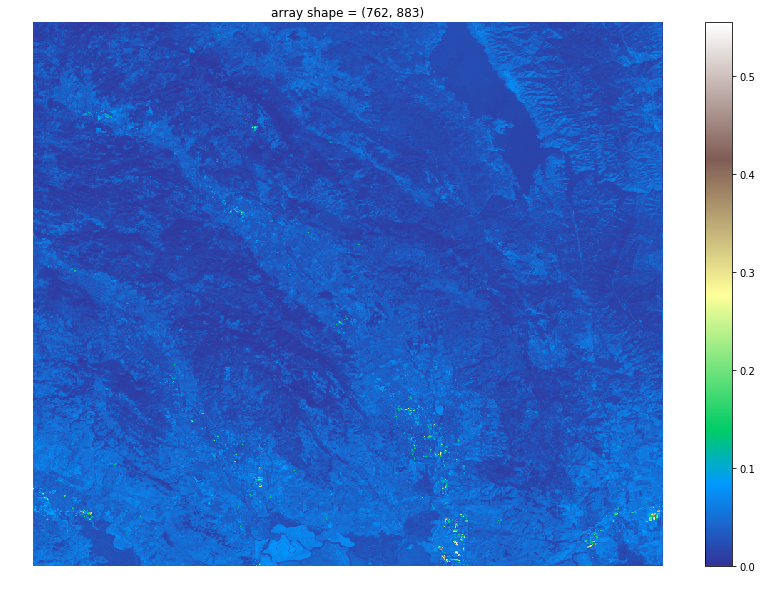

In [20]:
plt.imshow(im, cmap = "terrain")
plt.title("array shape = {}".format(im.shape))
plt.axis('off')
plt.colorbar()
plt.show()

# Chunk the images

In [21]:
def gen_polys(geometry, dx, dy):
    bounds = ee.Geometry(geometry).bounds()
    coords = ee.List(bounds.coordinates().get(0))
    ll = ee.List(coords.get(0))
    ur = ee.List(coords.get(2))
    xmin = ll.get(0)
    xmax = ur.get(0)
    ymin = ll.get(1)
    ymax = ur.get(1)

    latlist = ee.List.sequence(ymin, ymax, dx)
    lonlist = ee.List.sequence(xmin, xmax, dy)
    
    for lat in latlist.getInfo():
        def make_rect(lat):
            lattemp = ee.Number(lat)
            for lon in lonlist.getInfo():
                lontemp = ee.Number(lon)
                uplattemp = lattemp.subtract(dy)
                lowlontemp = lontemp.add(dx)
                return ee.Feature(ee.Geometry.Polygon([[lontemp, lattemp],
                                                        [lowlontemp, lattemp],
                                                        [lowlontemp, uplattemp],
                                                        [lontemp, uplattemp]]))
    s = latlist.map(make_rect).flatten()       
    
    return s #ee.FeatureCollection(s)

In [28]:
dx, dy = 0.1, 0.1
asdf = gen_polys(bounds, dx, dy)

In [29]:
polys = asdf.getInfo()

In [30]:
len(polys)

5

In [31]:
col = get_landsat(year).filterBounds(bounds).filterDate(start,end).map(mask_quality)
arrs = []

for i in polys:
    print(i['geometry']['coordinates'])
    aoi = ee.Geometry.Polygon(i['geometry']['coordinates'])
    arrs.append(array_from_col(col,res = 30, bounds = aoi))
    time.sleep(10)

[[[-122.63771239999998, 38.084655999999974], [-122.53771239999999, 38.084655999999974], [-122.53771239999999, 38.184655999999976], [-122.63771239999998, 38.184655999999976], [-122.63771239999998, 38.084655999999974]]]
[[[-122.63771239999998, 38.184655999999976], [-122.53771239999999, 38.184655999999976], [-122.53771239999999, 38.28465599999998], [-122.63771239999998, 38.28465599999998], [-122.63771239999998, 38.184655999999976]]]
[[[-122.63771239999998, 38.28465599999998], [-122.53771239999999, 38.28465599999998], [-122.53771239999999, 38.38465599999998], [-122.63771239999998, 38.38465599999998], [-122.63771239999998, 38.28465599999998]]]
[[[-122.63771239999998, 38.38465599999997], [-122.53771239999999, 38.38465599999997], [-122.53771239999999, 38.48465599999997], [-122.63771239999998, 38.48465599999997], [-122.63771239999998, 38.38465599999997]]]
[[[-122.63771239999998, 38.48465599999997], [-122.53771239999999, 38.48465599999997], [-122.53771239999999, 38.584655999999974], [-122.63771

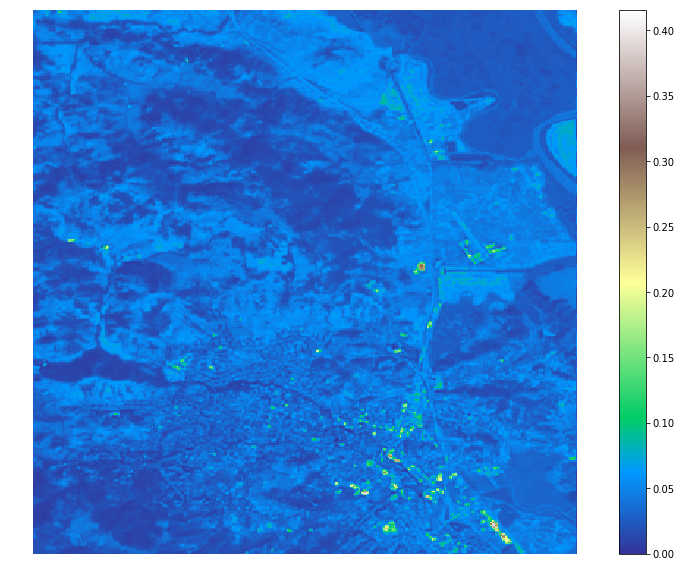

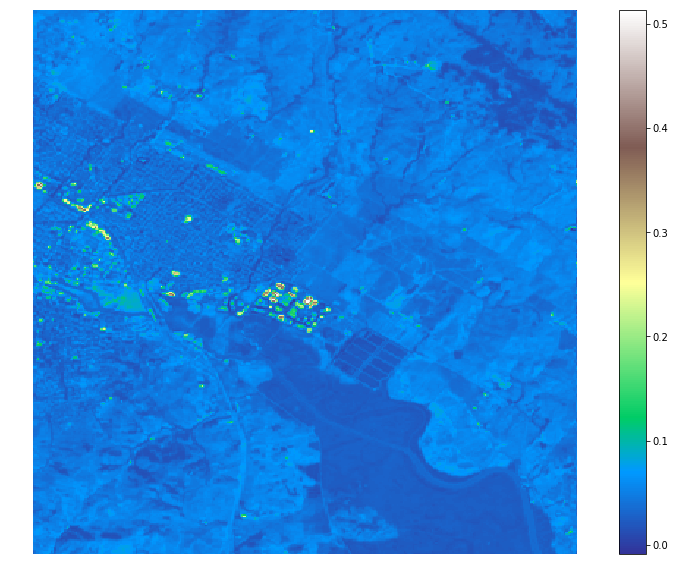

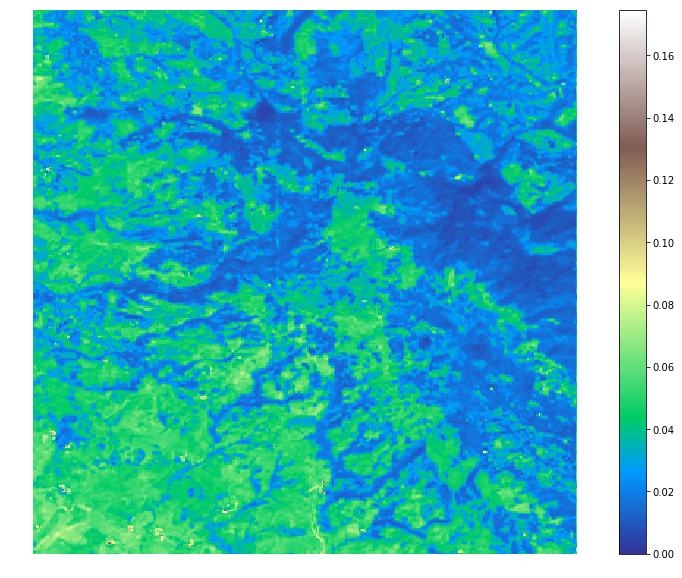

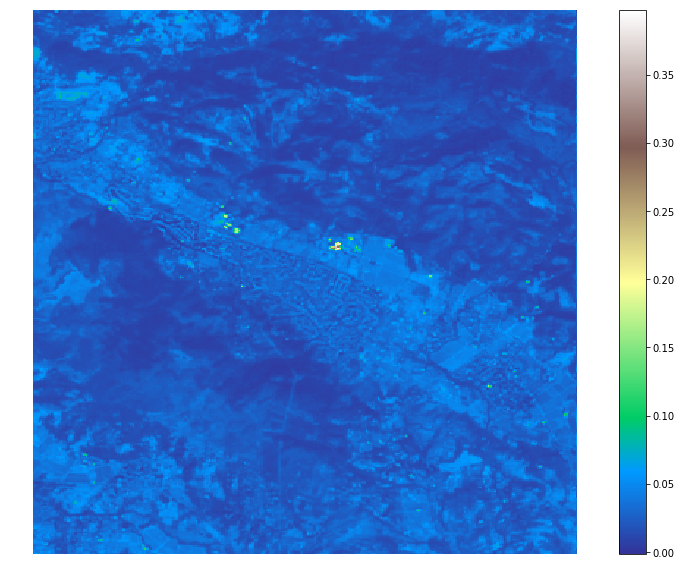

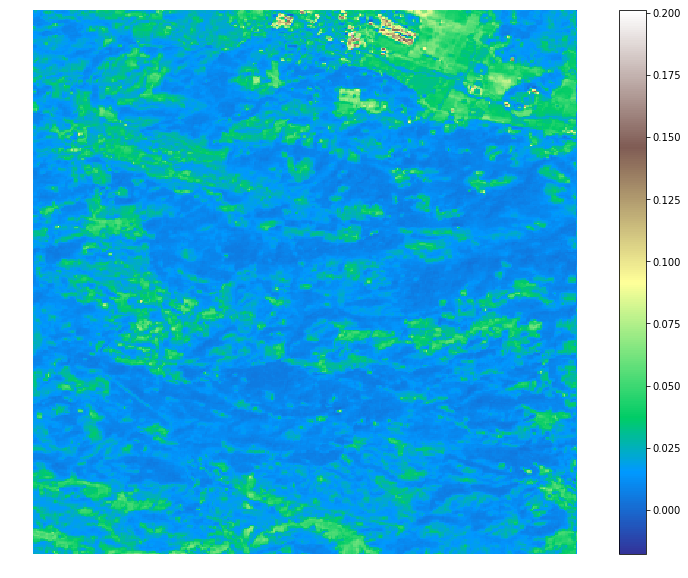

In [32]:
for i in arrs:
    plt.imshow(i, cmap = "terrain")
    plt.axis('off')
    plt.colorbar()
    plt.show()

# Task List:

Short term:
1. Chunk the sentinel grid
2. MODIS cloud masks
3. Filter LS / MODIS by landcover

Longer term: 
1. Modularize
2. Write the code for ET
    a. Pull CIMIS wind speed

Completed: 
1. Chunk grid to get full resolution



In [ ]:
'''
TODO:

1. Chunk grid to get full resolution [X]

2. Try out ee.Reducer.ToCollection
3. MODIS cloud masks 
4. Sentinel (optical) cloud masks and Sentinel Radar 
5. Landcover code 

Make it OOP!!!!

'''

# MODIS (done) 

In [ ]:
# Set the study years
year = 2017

In [ ]:
# Set the Study area (upoad kml to google fusion table, use the DocID in the ft string below)
area = (ee.FeatureCollection('ft:1QPasan0i6O9uUlcYkjqj91D7mbnhTZCmzS4t7t_g').filter(ee.Filter().eq('id', '107')))
bounds = area.geometry().bounds()

# Set the satellite data of interest
modis_ndvi = ee.ImageCollection('MCD43A4_NDVI')
modis_lc = ee.ImageCollection('MODIS/006/MCD12Q1')
modis_sr = ee.ImageCollection('MCD43A4')

In [ ]:
sr = ees.filter_modis_sr(year)
lc = ees.filter_modis_lc(year)

clipped_sr = ee.ImageCollection(sr.clip(bounds))
clipped_lc = ee.ImageCollection(lc.clip(bounds))

lc_out = clipped_lc.getRegion(bounds,250,"epsg:4326").getInfo()
sr_out = clipped_sr.getRegion(bounds,250,"epsg:4326").getInfo()

In [ ]:
tulare = eef.df_from_imcol(sr_out)
tulare_lc = eef.df_from_imcol(lc_out)

In [ ]:
bandnames = ["Nadir_Reflectance_Band1","Nadir_Reflectance_Band2","Nadir_Reflectance_Band3", "Nadir_Reflectance_Band4", "Nadir_Reflectance_Band5","Nadir_Reflectance_Band6", "Nadir_Reflectance_Band7"]

ims = []
for b in bandnames:
    ims.append(eef.array_from_df(tulare,b))

lcs = ["LC_Type1"]
ims.append(eef.array_from_df(tulare_lc,lcs[0]))

# Sanity check

In [ ]:
plt.figure(figsize = (10,10))

for i in range(len(ims)):
    spidx = i+1
    plt.subplot(4,2,spidx)
    try:
        plt.title("{}".format(bandnames[i]))
    except:
        plt.title("crop mask")
    plt.imshow(ims[i])
    plt.axis("off")
    plt.colorbar()
    
plt.tight_layout()
plt.show()

In [ ]:
# Grab the training data 
cwd = os.getcwd() #os.path.split(os.getcwd())[0]
y_dir = [os.path.join(cwd,x) for x in os.listdir(cwd) if "yield" in x][0]
fn = [os.path.join(y_dir,x) for x in os.listdir(y_dir) if "107" in x][0]

d = json.load(open(fn))
yrs = [str(x) for x in years]
d_2 = { year: d[year] for year in yrs }
training = d_2.values()

In [ ]:
features = np.array([np.ndarray.flatten(x) for x in ims])
labels = np.array(training)

# Test ML methods

In [ ]:
# Train / Test split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 10)

# NN naming convention
X_train = np.array(train_features)
X_test = np.array(test_features)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Simple NN

In [ ]:
def ff_nn(X_train):
    model = Sequential()
    model.add(Dense(85, input_dim=33150, activation='relu'))
    model.add(Dense(42, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
    
    return model

In [ ]:
# Visualize loss functions
plot_callback = PlotLossesKeras()

# Fit model
model = ff_nn(X_train)
model.fit(X_train, y_train, validation_data=[test_features,test_labels],epochs=300,verbose=1, callbacks = [plot_callback])

In [ ]:
predictions = model.predict(X_test).reshape(predictions.shape[0])
mape = 100. * (np.abs((predictions - y_test) / y_test))
np.mean(mape)

# Random Forest

In [ ]:
# Instantiate, train, predict 
rf = RandomForestRegressor(n_estimators= 10000)#, random_state=50)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)

# rf_new = RandomForestRegressor(n_estimators = 500, criterion = 'mse', max_depth = None, min_samples_split = 2, min_samples_leaf = 1)

In [ ]:
# Median Absolute Percentage Error Function
mape = 100 * (np.abs(((predictions) - (test_labels)) / (test_labels)))

print('Median Absolute Percentage Error: {} %'.format(str(round(np.median(mape), 2))))

In [ ]:
s = rf.feature_importances_
s.reshape(arrs[0].shape)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(s.reshape(arrs[0].shape))
plt.colorbar()


plt.subplot(1,2,2)
plt.imshow(arrs[0])

plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
arrs[0].shape